# Marker analysis

In this notebook we will identify the genes highly expressed in cells that feature high mapping score. Also we will use same method of differential expression test to ascertain the marker genes for each cluster in the reference SNN graph.

In [1]:
import nabo

We start by loading the mapped reference graph. Here we also visualize the mapping score for target 'ME'

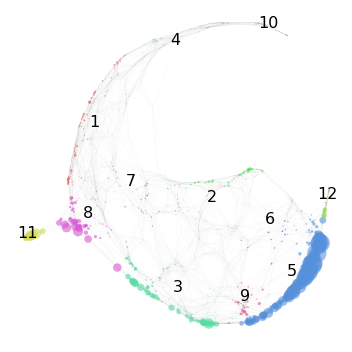

GraphPlot of 1414 nodes

In [2]:
hvg_graph = nabo.Graph()
hvg_graph.load_from_gml('../analysis_data/hvg_graph.gml')
nabo.GraphPlot(hvg_graph, vc_attr='cluster', label_attr='cluster',
               vs=hvg_graph.get_mapping_score(target='ME'))

Now we use [set_de_groups](../../../api.rst#nabo.Graph.set_de_groups) to identify marker genes for cells with high mapping score. `min_score` sets the cutoff for mapping score and the cell with higher score than this are marked as 'Test cells'. Using optional argument `from_clusters`, 'Test cell' selection can be restricted to certain clusters. The interesting aspect of [set_de_groups](../../../api.rst#nabo.Graph.set_de_groups) is how it selects the 'Control cells' to compare with 'Test cells'. 'Control cells' are selected based on their path distance from 'Test cells' on the graph. Each of the control cell will be not more than `node_dist` node away from 'Test cells'. Please [refer to documentation](../../../api.rst#nabo.Graph.set_de_groups) for more information on other parameters that regulate 'Control cell' selection. At the end we visualize which cells where marked as test and control cells.

Test nodes: 92, Control nodes: 89


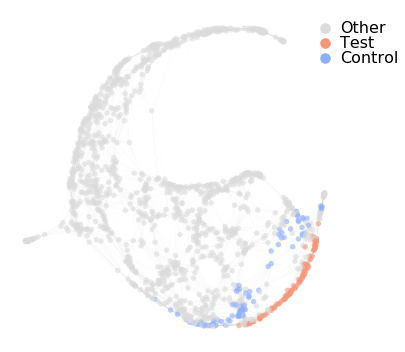

GraphPlot of 1414 nodes

In [3]:
hvg_graph.set_de_groups('ME', min_score=1, node_dist=2, from_clusters=['5'])
nabo.GraphPlot(hvg_graph, vc_attr='de_group', label_attr='de_group',
               label_attr_type='legend', cmap='coolwarm')

Since, the graph object does not store the gene expression values, we use [Dataset](../../../api.rst#dataset) class to load the data. The, we do not need to filter cells and genes again or set size factors because they were saved into the HDF5 file in the [Preprocessing notebook](1_preprocessing.ipynb).

In [4]:
wt_data = nabo.Dataset('../analysis_data/WT.h5')
me_data = nabo.Dataset('../analysis_data/MLL_ENL.h5')

INFO: Cached filtered gene and cell names loaded
INFO: Cached cell size factors loaded
INFO: Cached filtered gene and cell names loaded
INFO: Cached cell size factors loaded


Nabo keeps [Dataset](../../../api.rst#dataset) independet of [Graph](../../../api.rst#graph) class and hence the cell names in saved in the Dataset object are note same as those in the graph (because we appended reference name to them). So we save this info (not saved in HDF5) in Dataset object so that it dynamically appends reference names to cells.

In [5]:
wt_data.update_exp_suffix(hvg_graph.refName)

Now we are ready to perform marker identification, test cells are saved in `deTestCells` attribute and control cells in `deCtrlCells` attribute. We then call [run_de_test](../../../api.rst#nabo.run_de_test) method to run the differential expression test (Mann Whitney U test) between the two groups. The test will return a table containing names and other information on the genes with significantly high expression in test cells. Refer to [documentation](../../../api.rst#nabo.run_de_test) to check out additional parameters that regulate behaviour of this step.

The columns of this table are:
- `gene`: Gene name
- `exp_frac`: Fraction of test cells expressing (having non-zero value) this gene
- `test_group`: Name of test group. Can be ignored here as we had only test group here
- `versus_group`: Name of group against which the comparison was made. Can be ignored here as only one control group is defined here.
- `rbc`: Rank-biserial correlation
- `log_fc2`: Log2 fold change
- `pval`: p value
- `qval`: Benjamini-Hochberg corrected p value

In [6]:
wt_mapped_marker_table = nabo.run_de_test(
    wt_data, None,
    hvg_graph.deTestCells, [hvg_graph.deCtrlCells])
print (len(wt_mapped_marker_table), " DE genes found" )
wt_mapped_marker_table.head()

100%| 00:00

96  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,CTR9,1.000000,Test group,Ctrl group 0,0.750122,2.165372,1.391682e-18,1.377765e-16
1,GEM,0.695652,Test group,Ctrl group 0,0.638740,4.451066,4.069430e-17,2.014368e-15
2,PTPRCAP,1.000000,Test group,Ctrl group 0,0.712750,1.168224,6.207329e-17,2.048419e-15
3,IL12A,0.500000,Test group,Ctrl group 0,0.466781,4.457560,2.986793e-12,7.392313e-11
4,COX6A2,0.543478,Test group,Ctrl group 0,0.460186,3.085060,5.511344e-11,1.091246e-09


Expression of a gene can also be visualized on the graph using by setting `vc`, i.e. vertex color to the expression value of a gene which can be obtained using wt_Data.exp.<gene\>. `exp` attribute allows gene autocomplete functionality (can be activated by writing atleast one character after 'exp.' and then pressing TAB key ). The graph below shows expression of FLT3 with darker hue representing higher expression.

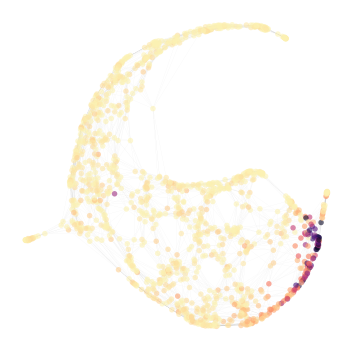

GraphPlot of 1414 nodes

In [7]:
nabo.GraphPlot(hvg_graph, vc=wt_data.exp.CTR9, cmap='magma_r', vc_percent_trim=1)

Expression distribution can also be vislualized as boxplots using `plot_box_exp` function.

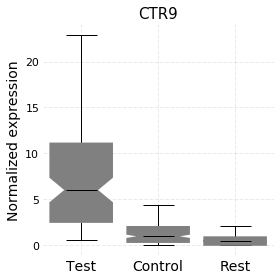

In [8]:
nabo.plot_box_exp(wt_data, 'CTR9',
                  [hvg_graph.deTestCells, hvg_graph.deCtrlCells],
                  ['Test', 'Control'])

[run_de_test](../../../api.rst#nabo.run_de_test) method is quote flexible and can easily be used to compare the genes across datasets as well. As an example below we test for upregulated genes in the WT cells marked as Test cells above while compare them to ME cells which projected onto these WT cells. [Graph](../../../api.rst#graph) has a handy method called [get_mapped_cells](../../../api.rst#nabo.Graph.get_mapped_cells) which can be used to identify cells that project onto any set of reference cells.

In [9]:
mapped_wt_vs_me_table = nabo.run_de_test(
    wt_data,
    me_data,
    hvg_graph.deTestCells,
    [hvg_graph.get_mapped_cells('ME', hvg_graph.deTestCells)])
print (len(mapped_wt_vs_me_table), " DE genes found" )
mapped_wt_vs_me_table

100%| 00:00

13  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,S100A9,0.989130,Test group,Ctrl group 0,0.987831,6.909157,4.121196e-34,5.769674e-33
1,S100A8,1.000000,Test group,Ctrl group 0,1.000000,5.071305,5.231598e-32,3.662119e-31
2,STFA1,0.815217,Test group,Ctrl group 0,0.813209,8.046106,7.429211e-27,3.466965e-26
3,BC100530,0.695652,Test group,Ctrl group 0,0.695652,inf,4.589945e-22,1.606481e-21
4,GM5483,0.543478,Test group,Ctrl group 0,0.537807,6.713838,7.024464e-16,1.966850e-15
5,CHIL3,0.500000,Test group,Ctrl group 0,0.500000,inf,6.686560e-15,1.560197e-14
6,IRF8,0.978261,Test group,Ctrl group 0,0.645085,1.329467,2.075967e-14,4.151934e-14
7,NGP,0.478261,Test group,Ctrl group 0,0.478261,inf,3.476140e-14,6.083246e-14
8,LY6C2,0.858696,Test group,Ctrl group 0,0.539698,1.045267,1.286188e-10,2.000737e-10
9,GT(ROSA)26SOR,0.586957,Test group,Ctrl group 0,0.451323,2.432640,9.471199e-10,1.325968e-09


To look for upregulated genes other way round, we simply swtich the order of parameters as below.

In [10]:
mapped_me_vs_wt_table = nabo.run_de_test(
    me_data,
    wt_data,
    hvg_graph.get_mapped_cells('ME', hvg_graph.deTestCells),
    [hvg_graph.deTestCells])
print (len(mapped_me_vs_wt_table), " DE genes found" )
mapped_me_vs_wt_table.head(n=10)

100%| 00:00

280  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,CAR2,0.983940,Test group,Ctrl group 0,0.982020,7.976296,6.171321e-55,1.734141e-52
1,CTLA2A,0.935760,Test group,Ctrl group 0,0.882087,4.551694,9.122579e-45,1.281722e-42
2,MEIS1,0.925054,Test group,Ctrl group 0,0.823806,3.101246,2.515274e-39,2.355974e-37
3,H2-D1,1.000000,Test group,Ctrl group 0,0.820757,1.428702,5.864358e-39,4.119711e-37
4,HOXA9,0.929336,Test group,Ctrl group 0,0.795922,2.699476,7.893995e-37,3.697021e-35
5,IKZF2,0.800857,Test group,Ctrl group 0,0.789289,6.353310,7.254986e-37,3.697021e-35
6,CD34,0.938972,Test group,Ctrl group 0,0.757879,2.163252,1.512775e-33,6.072709e-32
7,VAMP5,0.837259,Test group,Ctrl group 0,0.752304,3.568102,2.205874e-33,7.748132e-32
8,HOXA7,0.955032,Test group,Ctrl group 0,0.746741,1.966776,1.297193e-32,4.050124e-31
9,ADGRL4,0.725910,Test group,Ctrl group 0,0.721558,7.743744,1.028170e-31,2.889157e-30


Now let's identify marker genes for each reference graph cluster using [find_cluster_markers](../../../api.rst#nabo.find_cluster_markers) function. This returns two values, first,  a table containing list of differentially expressed genes between each pair of clusters (in same format as seen above). Same gene can occur multiple times as it will tested for multiple pair of clusters. The second returned value is a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp) containing only names of marker genes as values and each key is the cluster number. Here we call [find_cluster_markers](../../../api.rst#nabo.find_cluster_markers) function with following parameter:
- Graph object (hvg_graph). Cluster information will automatically loaded from it.
- Dataset object (wt_data)
- `de_frequency` (4). This value decides across how many cluster comparisons should a gene be significantly differentially cluster for it to be called a marker gene for a given cluster. For example, For FLT3 to be called marker for cluster 2 it should come up atleast 4 times as having significantly high expression when compared to rest of clusters. A gene is allowed to be called a marker gene for more than one cluster.
- `exp_frac_thresh` (0.5). For a gene to be tested for a given cluster it should be expressed in atleast 50% of cells.
- `log_fc_thresh` (1). Gene should have log2 foldchange >= 1 for mean values.

In [11]:
marker_table, marker_genes = nabo.find_cluster_markers(
    hvg_graph, wt_data, de_frequency=4, exp_frac_thresh=0.5, log2_fc_thresh=1)

Finding markers for cluster 1: 100%| 00:00
Finding markers for cluster 10: 100%| 00:00
Finding markers for cluster 11: 100%| 00:00
Finding markers for cluster 12: 100%| 00:00
Finding markers for cluster 2: 100%| 00:00
Finding markers for cluster 3: 100%| 00:00
Finding markers for cluster 4: 100%| 00:00
Finding markers for cluster 5: 100%| 00:00
Finding markers for cluster 6: 100%| 00:00
Finding markers for cluster 7: 100%| 00:00
Finding markers for cluster 8: 100%| 00:00
Finding markers for cluster 9: 100%| 00:00


Lets check out how many genes marker genes were found for each cluster.

In [12]:
for cluster in marker_genes:
    print (cluster, len(marker_genes[cluster]))

1 226
10 225
11 101
12 140
2 298
3 143
4 279
5 188
6 260
7 133
8 97
9 71
